# SINDyCP Feature Overview
This notebook provides an overview of the SINDyCP for discovery of parameterized pattern formation in PySINDy. Jupyter notebook written by Zachary G. Nicolaou.

In [1]:
import matplotlib.pyplot as plt
from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
import timeit
import os

In [2]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'RK45'
integrator_keywords['atol'] = 1e-12

### Fit a parameterized logistic map
The logistic map
$$ x_{n+1} = r x_n(1-x_n)$$
depends on one parameter $r$. 

The behavior is chaotic for r>3.6

In [3]:
num=1000
N=1000
N_drop=500
r0=3.5
rs=r0+np.arange(num)/num*(4-r0)
xss=[]
for r in rs:
    xs=[]
    x=0.5
    for n in range(N+N_drop):
        if n>=N_drop:
            xs=xs+[x]
        x=r*x*(1-x)
    xss=xss+[xs]

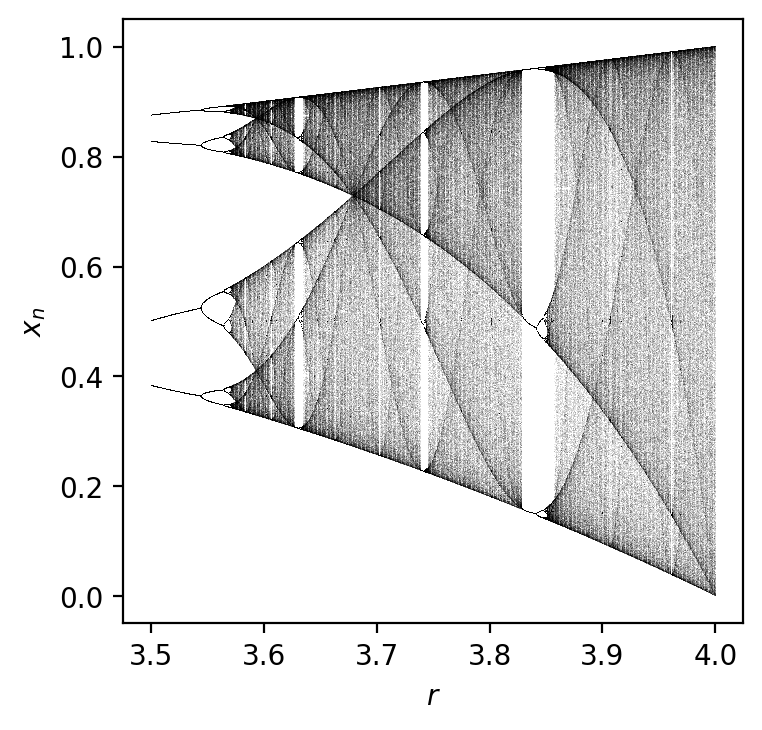

In [4]:
plt.figure(figsize=(4,4),dpi=200)
for ind in range(num):
    plt.plot(np.ones(N)*rs[ind],xss[ind], ',', alpha=0.1, c='black', rasterized=True)
plt.xlabel('$r$')
plt.ylabel('$x_n$')
plt.savefig('logistic.pdf')
plt.show()

We fit a SINDyCP model from four trajectories with differing values of $r$

In [5]:
N=1000
N_drop=500

rs=[3.6,3.7,3.8,3.9]
xss=[]
for r in rs:
    xs=[]
    x=0.5
    for n in range(N+N_drop):
        if n>=N_drop:
            xs=xs+[x]
        x=r*x*(1-x)
    xss=xss+[np.array(xs)]

In [6]:
feature_lib=ps.PolynomialLibrary(degree=3,include_bias=True)
parameter_lib=ps.PolynomialLibrary(degree=1,include_bias=True)
lib=ps.ParameterizedLibrary(feature_library=feature_lib,parameter_library=parameter_lib,num_features=1,num_parameters=1)
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'r'], discrete_time=True)
model.fit(xss, u=[np.ones(N)*rs[ind] for ind in range(len(rs))], multiple_trajectories=True)
model.print()


(x)[k+1] = 1.000 r[k] x[k] + -1.000 r[k] x[k]^2


### Fit a parameterized Lorenz model
The Lorenz equations
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$
depend on 3 parameters, $\sigma$, $\rho$, and $\beta$. We generate 10 trajectories with different parameter values.

In [7]:
start=timeit.default_timer()

dt = .002
num_trajectories=5
scalesigma=1
scalerho=1
scalebeta=1

np.random.seed(100)
sigmas=10 + scalesigma*(np.random.random(num_trajectories)-0.5)
rhos=28*np.ones(num_trajectories) + scalerho*(np.random.random(num_trajectories)-0.5)
betas=2.66667*np.ones(num_trajectories) + scalebeta*(np.random.random(num_trajectories)-0.5)
x_trains=[]
t_trains=[]

for i in range(len(sigmas)):
    t_train = np.arange(0, 10, dt)
    x0_train = [-8, 8, 27]
    t_train_span = (t_train[0], t_train[-1])
    x_train = solve_ivp(lorenz, t_train_span, x0_train, args=(sigmas[i],betas[i],rhos[i]),
                    t_eval=t_train, **integrator_keywords).y.T
    x_trains=x_trains+[x_train]
    t_trains=t_trains+[t_train]

stop=timeit.default_timer()
print(stop-start)

5.282390940000001


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [8]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains[-1], t=dt)
model.print()
print([sigmas[-1],rhos[-1],betas[-1]])
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -9.504 x + 9.504 y
(y)' = 28.068 x + -0.999 y + -1.000 x z
(z)' = -2.386 z + 1.000 x y
[9.504718856190973, 28.07509332942725, 2.3863674926249923]
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


We use the control input of ps.model to specify the parameter values, and fit a SINDy model with multiple trajectories.

Create list of control inputs corresponding to the parameters. The control inputs have the same shape as the data, but are constant across the temporal grid.

In [9]:
sigmas_timeseries=np.array(sigmas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
rhos_timeseries=np.array(rhos)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
betas_timeseries=np.array(betas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
u_trains=[np.concatenate([np.transpose([sigmas_timeseries[i]]),np.transpose([rhos_timeseries[i]]),np.transpose([betas_timeseries[i]])],axis=1) for i in range(num_trajectories)]

Fitting a PolynomialLibrary with multiple_trajectories=True gives the correct model, but note that the same library functions are applied to the input features and the control input.

In [10]:
lib=ps.PolynomialLibrary()
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 x sigma + 1.000 y sigma
(y)' = -0.999 y + -1.000 x z + 1.000 x rho
(z)' = 1.000 x y + -1.000 z beta
['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']


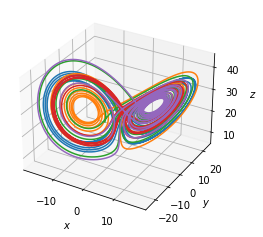

In [11]:
fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection='3d')

for i in range(num_trajectories):
    ax.plot(x_trains[i][:,0],x_trains[i][:,1],x_trains[i][:,2])
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
plt.savefig('lorenz.pdf')
plt.show()

The ParameterizedLibrary enables different libraries to be applied to the control input and input features. In this case, the result is the same, but different libraries are required for the PDE case, as shown below.

In [12]:
feature_library=ps.PolynomialLibrary(degree=2)
parameter_library=ps.PolynomialLibrary(degree=1)
lib=ps.ParameterizedLibrary(feature_library=feature_library,parameter_library=parameter_library, num_parameters=3)
opt=ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 sigma x + 1.000 sigma y
(y)' = -0.999 1 y + -1.000 1 x z + 1.000 rho x
(z)' = 1.000 1 x y + -1.000 beta z
['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'rho 1', 'rho x', 'rho y', 'rho z', 'rho x^2', 'rho x y', 'rho x z', 'rho y^2', 'rho y z', 'rho z^2', 'beta 1', 'beta x', 'beta y', 'beta z', 'beta x^2', 'beta x y', 'beta x z', 'beta y^2', 'beta y z', 'beta z^2']


### Fit a parameterized complex Ginzburg-Landau equation
The complex Ginzburg-Landau equation
$$ \dot{A} = A + (1+ib)\nabla^2 A - (1-ic)|A|^2A$$
describes the evolution of the mode amplitude $A$ for pattern formation in a long-wavelength, supercritical Hopf bifurcation. It depends on two parameters $b$ and $c$. We generate 4 trajectories with different values of the parameters. (Note: this will take a few minutes on the first run, but trajectories are saved and reloaded if present)

In [13]:
nx=128
ny=128
N=nx*ny
L=16
t1=2e2
t3=1.9e2
dt=1e-1
nt=int((t1-t3)/dt)
def cgle(t, Z, b, c):
    Zxxr=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.real(Z).reshape((nx,ny)),1.0/nx)
    Zyyr=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.real(Z).reshape((nx,ny)),1.0/ny)
    Zxxi=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/nx)
    Zyyi=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/ny)
    lap=(Zxxr+1j*Zxxi+Zyyr+1j*Zyyi).reshape(N)    
    return Z - (1-1j*c)*Z*Z*Z.conjugate() + (1+1j*b)*lap/(2*np.pi*L)**2


spatial_grid=np.zeros((nx,ny,2))
spatial_grid[:,:,0]=(np.arange(nx)-nx//2)[:,np.newaxis]*2*np.pi*L/nx
spatial_grid[:,:,1]=(np.arange(nx)-nx//2)[np.newaxis,:]*2*np.pi*L/nx
spatiotemporal_grid=np.zeros((nx,ny,100,3))
spatiotemporal_grid[:,:,:,:2]=spatial_grid[:,:,np.newaxis,:]
spatiotemporal_grid[:,:,:,2]=dt*np.arange(100)

In [14]:
bs=[2.0,2.0,0.5,1.0]
cs=[1.0,0.75,0.5,0.75]
scales=[1e-1,1e-1,1e-1,1e0]
scales2=[1e-2,1e-2,1e0,1e-2]

if np.all([os.path.exists('data/cgle/cgle_x'+str(i)+'.npy') for i in range(4)]):
    xs=[np.load('data/cgle/cgle_x'+str(i)+'.npy') for i in range(4)]
    us=[np.load('data/cgle/cgle_u'+str(i)+'.npy') for i in range(4)]
else:
    xs=[]
    for i in range(len(bs)):
        b=bs[i]
        c=cs[i]
        scale0=scales[i]
        scale2=scales2[i]
        start=timeit.default_timer()

        ks=np.arange(-2,3)
        phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
        kx=2
        ky=2
        phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) - 1)

        np.random.seed(100)
        for kx in ks:
            for ky in ks:
                scale=scale0/(1+(kx**2+ky**2))**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 

        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        times=[]
        dt1=dt/1000
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            times.append(sol.t)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,nt,2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        xs.append(x)

    #Create list of control inputs corresponding to the parameters. 
    #The control inputs have the same shape as the data, 
    #but are constant across the spatiotemporal grid.
    us=[]
    for i in range(4):
        b=bs[i]
        c=cs[i]
        u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
        u[:,:,:,0]=b
        u[:,:,:,1]=c
        us.append(u)
        
    for i in range(len(xs)):
        if not os.path.exists('data/cgle'):
            os.mkdir('data/cgle')
        np.save('data/cgle/cgle_x'+str(i),xs[i])
        np.save('data/cgle/cgle_u'+str(i),us[i])

Depending on the parameter values and initial conditions, the system exhibits different dynamical phases.

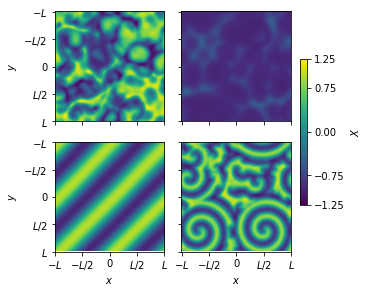

In [15]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,axs=plt.subplots(2,2,figsize=(5,4), constrained_layout=True)

for i in range(len(xs)):
    plt.subplot(2,2,i+1)
    pl=plt.imshow(xs[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    if i==2 or i==3:
        plt.xlabel('$x$')
    else:
        plt.gca().set_xticklabels([])
    if i==0 or i==2:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
cbar=plt.colorbar(pl,ax=axs[:,1],orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$',shrink=0.6)
plt.savefig('cgle.pdf')
plt.show()


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [16]:
start=timeit.default_timer()
lib=ps.PDELibrary(library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x],derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,  lambda x,y:x+y+y])
lib.differentiation_method=ps.SpectralDerivative
lib.diff_kwargs={}
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['X', 'Y'])
model.fit(xs[-1],t=dt)
model.print()
stop=timeit.default_timer()
print(stop-start)

(X)' = 0.999 X + -0.999 XXX + -0.750 YYY + -0.750 XXY + -0.999 XYY + 0.999 X_22 + -0.999 Y_22 + 0.999 X_11 + -0.999 Y_11
(Y)' = 0.999 Y + 0.750 XXX + -0.999 YYY + -0.999 XXY + 0.750 XYY + 0.999 X_22 + 0.999 Y_22 + 0.999 X_11 + 0.999 Y_11
5.995773486000001


Try a SINDy model with multiple trajectories using the ParameterizedLibrary. Use a PDELibrary for the feature_library with second-order derivatives and library functions that include the relevant cubic term. Use a PDELibrary for the parameter_library with zeroth-order derivatives and linear library functions. The fit is very good!

In [17]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.989 1 x + -0.987 1 xxx + -0.987 1 xyy + 1.014 1 x_22 + 1.021 1 x_11 + -1.013 b y_22 + -1.020 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 0.987 1 y + -0.985 1 yyy + -0.985 1 xxy + 1.011 1 y_22 + 1.019 1 y_11 + 1.012 b x_22 + 1.022 b x_11 + 1.000 c xxx + 0.999 c xyy
107.21791592599999
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


Modifying PDELibrary to accept spectral derivatives improves the fit a bit

In [18]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
feature_lib.differentiation_method=ps.SpectralDerivative
feature_lib.diff_kwargs={}
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.999 1 x + -0.999 1 xxx + -0.999 1 xyy + 0.999 1 x_22 + 0.999 1 x_11 + -0.999 b y_22 + -0.999 b y_11 + -0.999 c yyy + -0.999 c xxy
(y)' = 0.999 1 y + -0.999 1 yyy + -0.999 1 xxy + 0.999 1 y_22 + 0.999 1 y_11 + 0.999 b x_22 + 0.999 b x_11 + 0.999 c xxx + 0.999 c xyy
117.28213514699999
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


If we ensure the same domain cells are used in the feature library and the parameter library (by reseeding np.random), the WeakLibrary can be used with the ParameterLibrary. (In this case, the parameters need to be constants, so that the tensor product of two WeakLibrary corresponds to the correct weak features.) The fit is perfect and super fast!

In [19]:
start=timeit.default_timer()
np.random.seed(100)
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
np.random.seed(100)
library_functions=[lambda x:x]
function_names=[lambda x:x]
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True,K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 1.000 1 x + -1.000 1 xxx + -1.000 1 xyy + 1.000 1 x_22 + 1.000 1 x_11 + -1.000 b y_22 + -1.000 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 1.000 1 y + -1.000 1 yyy + -1.000 1 xxy + 1.000 1 y_22 + 1.000 1 y_11 + 1.000 b x_22 + 1.000 b x_11 + 1.000 c xxx + 1.000 c xyy
21.763303307
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


### animation

In [23]:
if False:
    if not os.path.exists('animation'):
        os.mkdir('animation')
    xs=[np.load('data/cgle/cgle_x'+str(i)+'.npy') for i in range(4)]
    us=[np.load('data/cgle/cgle_u'+str(i)+'.npy') for i in range(4)]
    bs=[us[i][0,0,0,0] for i in range(4)]
    cs=[us[i][0,0,0,1] for i in range(4)]

    xs_animation=[]
    t1=100

    for i in range(len(bs)):
        b=bs[i]
        c=cs[i]
        phase_init = xs[i][:,:,-1,0]+1j*xs[i][:,:,-1,1]
        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        dt1=dt/1000
        start=timeit.default_timer()
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,int(t1/dt),2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny)).transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny)).transpose((1,2,0)))
        xs_animation.append(x)

    if not os.path.exists('animation'):
        os.mkdir('animation')

    start=timeit.default_timer()
    for n in range(xs_animation[0].shape[2]):
        print(n,end='  \r')
        fig,axs=plt.subplots(2,2,figsize=(5,4.5), constrained_layout=True)
        for i in range(len(xs_animation)):
            plt.subplot(2,2,i+1)
            phase=(np.arctan2(xs_animation[i][:,:,n,0],xs_animation[i][:,:,n,1])+np.pi)/(2*np.pi)
            amp=(xs_animation[i][:,:,n,0]**2+xs_animation[i][:,:,n,1]**2)**0.5/1.5
#             plot=np.flip(np.triu(amp)+np.tril(phase,k=-1),axis=0)
            plot=np.triu(amp)+np.tril(phase,k=-1)
            pl=plt.pcolormesh(plot,vmin=0,vmax=1,cmap='twilight')
            plt.gca().set_xticks([0,32,64,96,128])
            plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
            plt.gca().set_yticks([0,32,64,96,128])
            plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
            if i==2 or i==3:
                plt.xlabel('$x$')
            else:
                plt.gca().set_xticklabels([])
            if i==0 or i==2:
                plt.ylabel('$y$')
            else:
                plt.gca().set_yticklabels([])

        cbar2=plt.colorbar(pl,ax=axs[:,:],orientation="horizontal",location='top',ticks=[0,0.25,0.5,0.75,1],label='$\phi/2\pi$',shrink=0.6)
        cbar=plt.colorbar(pl,ax=axs[:,:],orientation="vertical",ticks=[0,0.25,0.5,0.75,1],label='$r/1.5$',shrink=0.6)
        plt.savefig('animation/%04d.png'%(n),pad_inches=0.5,dpi=200,bbox_inches='tight')
        plt.close()

    stop=timeit.default_timer()
    print(stop-start)


### Oregenator model for BZ chemical reaction

We consider the coupled reaction diffusion equations

$\dot{C}_X = k_1 C_A C_H^2 C_Y-k_2C_HC_XC_Y+k_3C_AC_HC_X-2k_4C_X^2  + D_X \nabla^2 C_X$
$\dot{C}_Y = -k_1C_AC_H^2C_Y-k_2C_HC_XC_Y + \nu k_5 C_B C_Z + D_Y \nabla^2 C_Y$
$\dot{C}_Z = 2k_3C_AC_HC_X-k_5C_BC_Z + D_Z \nabla^2 C_Z$

which constitute the classical Oregonator model for the BZ chemical reaction. We fix all parameters except $C_b=C_b^c(1 - \mu)$, and a supercritical Hopf bifurcation at $\mu=0$. In the spatially homogeneous case, a small, stable limit cycle initially emerges for $\mu>0$, but this limit cycle rapid expands in a canard explosion around $\mu\approx 0.15$.

In [24]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['atol'] = 1e-12
integrator_keywords['method'] = 'RK45' 

k1=2
k2=1e6
k3=10
k4=2e3
k5=1
H=0.5
A=1
B=A*0.786642
h=1.0

def oregonator_homogeneous(t, u, b):
    X = u[0]
    Y = u[1]
    Z = u[2]
    Xt = k1*A*H*H*Y-k2*H*X*Y+k3*A*H*X-2*k4*X*X
    Yt = -k1*A*H*H*Y-k2*H*X*Y+k5*h*b*B*Z
    Zt = 2*k3*A*H*X-k5*b*B*Z
    return np.array([Xt,Yt,Zt])

In [25]:
bs3=np.linspace(0.84,0.98,8)

Xs=[]
Ys=[]
Zs=[]
for b in bs3:
    t1=1e2/(1-b) # Domain size in t directions
    dt=5.94804/100
    nt=int(np.round(t1/dt))
    t = dt*np.arange(nt)

    X=np.zeros((nt))
    Y=np.zeros((nt))
    Z=np.zeros((nt))

    start=timeit.default_timer()
    u0=np.array([2.99045e-6,0.000014988,0.000037639])*1.1
    ut=u0
    X[0]=ut[0]
    Y[0]=ut[1]
    Z[0]=ut[2]
    dt=t[1]-t[0]/2
    print('%.2f\r'%(b),end='',flush=True)
    for i in range(len(t)-1):
        usol = solve_ivp(oregonator_homogeneous, (t[i], t[i+1]), args=(b,), y0=ut, first_step=dt, **integrator_keywords)
        dt=np.diff(usol.t)[-1]
        ut = usol.y[:,-1]
        X[i+1]=ut[0]
        Y[i+1]=ut[1]
        Z[i+1]=ut[2]
    Xs=Xs+[X]
    Ys=Ys+[Y]
    Zs=Zs+[Z]

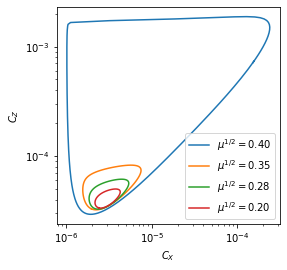

In [26]:
from scipy.signal import find_peaks
plt.figure(figsize=(4,4))
for i in range(0,len(bs3),2):
    X=Xs[i]
    Z=Zs[i]
    nt=X.shape[0]
    period=int(np.median(np.diff(find_peaks(X[nt//2:])[0])))+1
    plt.plot(X[-period:],Z[-period:],label='$\mu^{1/2} = %.2f$'%((1-bs3[i])**0.5))
plt.xlabel('$C_X$')
plt.ylabel('$C_Z$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.savefig('fig2b.pdf')
plt.show()

Spatiotemporal models with diffusion

In [27]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['atol'] = 1e-12
integrator_keywords['method'] = 'RK45' 

k1=2
k2=1e6
k3=10
k4=2e3
k5=1
Dx=1e-5
Dy=1.6e-5
Dz=0.6e-5
H=0.5
A=1
B=A*0.786642
h=1.0

def oregonator(t, u, b):
    X = np.reshape(u[:n*n], (n, n))
    Y = np.reshape(u[n*n:2*n*n], (n, n))
    Z = np.reshape(u[2*n*n:3*n*n], (n, n))
    dX=ps.SpectralDerivative(d=2,axis=0)._differentiate(X,L/n)+ps.SpectralDerivative(d=2,axis=1)._differentiate(X,L/n)
    dY=ps.SpectralDerivative(d=2,axis=0)._differentiate(Y,L/n)+ps.SpectralDerivative(d=2,axis=1)._differentiate(Y,L/n)
    dZ=ps.SpectralDerivative(d=2,axis=0)._differentiate(Z,L/n)+ps.SpectralDerivative(d=2,axis=1)._differentiate(Z,L/n)
    Xt = k1*A*H*H*Y-k2*H*X*Y+k3*A*H*X-2*k4*X*X+Dx*dX
    Yt = -k1*A*H*H*Y-k2*H*X*Y+k5*h*b*B*Z+Dy*dY
    Zt = 2*k3*A*H*X-k5*b*B*Z+Dz*dZ
    ut_updated = np.concatenate([Xt.ravel(), Yt.ravel(), Zt.ravel()])
    return ut_updated

Intial conditions

1.234024684624032e-06

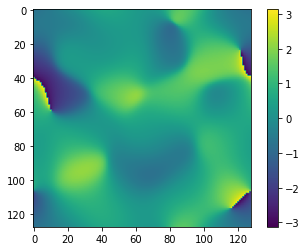

In [28]:
n = 128  # Number of spatial points in each direction

scale0=2e-1
scale2=0
ks=np.arange(-3,4)
phase_init=np.zeros((n,n),dtype=np.complex128)+1
kx=2
ky=2
phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/n * np.arange(n)[:,np.newaxis]+2*np.pi * ky/n * np.arange(n)[np.newaxis,:])) - 1)

np.random.seed(100)
for kx in ks:
    for ky in ks:
        scale=scale0/(1+(kx**2+ky**2))**0.5
        phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/n * np.arange(n)[:,np.newaxis]+2*np.pi * ky/n * np.arange(n)[np.newaxis,:])) 

phase=phase_init.reshape(n*n)

X0 = np.zeros((n, n))+2.99045e-6*(1+np.real(phase_init))
Y0 = np.zeros((n,n))+0.000014988*(1+np.real(phase_init))
Z0 = np.zeros((n,n))+0.0000380154*(1+np.imag(phase_init))
u0 = np.concatenate([X0.ravel(),Y0.ravel(),Z0.ravel()])
plt.imshow(np.angle(phase_init))
plt.colorbar()
np.min([X0,Y0,Z0])

Integrate six trajectories with varying bs. This will take several hours to generate the data for the first time.

In [29]:
bs=np.linspace(0.88,0.98,6)
Nt=1000

if not np.all([os.path.exists('data/oregonator_'+str(i)+'.npy') for i in range(len(bs))]):
    for j in range(len(bs)):
        if not os.path.exists('data/oregonator_'+str(j)+'.npy'):
            b=bs[j]
            print(j, b)
            L=1/(1-b)**0.5  # Domain size in X and Y directions
            t1=1e3/(1-b) # Domain size in t directions
            dt=5.94804
            nt=int(np.round(t1/dt))
            t = dt*np.arange(nt)

            X=np.zeros((n,n,nt))
            Y=np.zeros((n,n,nt))
            Z=np.zeros((n,n,nt))

            start=timeit.default_timer()
            ut=u0
            X[:,:,0]=ut[:n*n].reshape((n,n))
            Y[:,:,0]=ut[n*n:2*n*n].reshape((n,n))
            Z[:,:,0]=ut[2*n*n:3*n*n].reshape((n,n))
            dt=t[1]-t[0]/2
            try:
                for i in range(len(t)-1):
                    print('%.3f\t\r'%(i/len(t)),end='')
                    usol = solve_ivp(oregonator, (t[i], t[i+1]), args=(b,), y0=ut, first_step=dt, **integrator_keywords)
                    if not usol.success:
                        print(usol.message)
                        break

                    dt=np.diff(usol.t)[-1]
                    ut = usol.y[:,-1]
                    X[:,:,i+1]=ut[:n*n].reshape((n,n))
                    Y[:,:,i+1]=ut[n*n:2*n*n].reshape((n,n))
                    Z[:,:,i+1]=ut[2*n*n:3*n*n].reshape((n,n))
            except KeyboardInterrupt:
                print('keyboard!')

            x=np.array([X,Y,Z]).transpose(1,2,3,0)
            nt=x.shape[2]
            fi=interp1d(np.arange(x.shape[2]),x,axis=2)
            x=fi(np.arange(Nt)/(Nt-1)*(x.shape[2]-1))
            plt.plot(np.mean(x[:,:,:,0],axis=(0,1)))
            plt.plot(np.mean(x[:,:,:,2],axis=(0,1)))
            plt.show()
            plt.imshow(x[:,:,-1,0])
            plt.show()

            np.save('data/oregonator_'+str(j),x)
            stop=timeit.default_timer()
            print(stop-start)

xs=[np.load('data/oregonator_'+str(i)+'.npy') for i in range(len(bs))]

The SINDyCP fit reveals variations in the normal-form parameter that correct the weakly-nonlinear theory away from the instability, and these variations become extreme at the canard explosion. This requires a lot (>100gb) of memory and should be run on a cluster machine.  

In [30]:
xs_train=[]
xs_test=[]
for i in range(len(bs)):
    U=xs[i][:,:,2*Nt//5:,[0,2]]
    U=U-np.mean(U,axis=(0,1,2))
    U=U/np.mean(U**2,axis=(0,1,2))**0.5
#     xs_train=xs_train+[U[:,:,:2*Nt//5]]
#     xs_test=xs_test+[U[:,:,2*Nt//5:]]
    xs_train=xs_train+[U[:,:,:Nt//10]]
    xs_test=xs_test+[U[:,:,-Nt//10:]]
us=[]
us_test=[]
for i in range(len(bs)):
#     u=np.zeros((n,n,2*Nt//5))
    u=np.zeros((n,n,Nt//10))
    u[:]=(1-bs[i])**0.5
    us=us+[u[:,:,:,np.newaxis]]
#     u=np.zeros((n,n,2*Nt//5))
    u=np.zeros((n,n,Nt//10))
    u[:]=(1-bs[i])**0.5
    us_test=us_test+[u[:,:,:,np.newaxis]]

In [ ]:
spatial_grid=np.zeros((n,n,2))
spatial_grid[:,:,0]=2*np.arange(n)[:,np.newaxis]
spatial_grid[:,:,1]=2*np.arange(n)[np.newaxis,:]
nt=xs_train[0].shape[2]
dt=1e2/nt

library_functions=[lambda x:x, lambda x:x**2, lambda x,y:x*y, 
                   lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x, 
                   lambda x: x**4, lambda x,y: x**3*y, lambda x,y: x**2*y**2, lambda x,y: x*y**3, 
                   lambda x: x**5, lambda x,y: x**4*y, lambda x,y: x**3*y**2, lambda x,y: x**2*y**3, lambda x,y: x*y**4]
function_names=[lambda x:x, lambda x: x+x, lambda x,y:x+y, 
                    lambda x:x+x+x, lambda x,y:x+x+y,  lambda x,y:x+y+y, 
                    lambda x:x+x+x+x, lambda x, y: x+x+x+y, lambda x,y: x+x+y+y, lambda x,y: x+y+y+y, 
                    lambda x: x+x+x+x+x, lambda x,y: x+x+x+x+y, lambda x,y: x+x+x+y+y, lambda x,y: x+x+y+y+y, lambda x,y: x+y+y+y+y]
feature_lib=ps.PDELibrary(library_functions=library_functions,
                  derivative_order=2,spatial_grid=spatial_grid, temporal_grid=dt*np.arange(nt),include_interaction=False, implicit_terms=True,
                  function_names=function_names)
feature_lib.differentiation_method=ps.SpectralDerivative
feature_lib.diff_kwargs={}
feature_lib.multiindices=np.array([[0,0,1],[0,2,0],[2,0,0]])
feature_lib.num_derivatives=len(feature_lib.multiindices)

library_functions=[lambda x:x, lambda x:x**2]
function_names=[lambda x:x, lambda x:x+x]

parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=1,num_features=2)
lib.fit(np.concatenate([xs_train[0],us[0]],axis=-1))

n_targets = 2
num_mus=1+len(library_functions)
constraint_rhs = np.zeros(4*num_mus)
n_features=len(lib.get_feature_names())
constraint_lhs = np.zeros((4*num_mus, n_targets * n_features))
x11inds=np.where(np.array([name.split(' ')[1] for name in lib.get_feature_names()])=='x0_11')[0]
x22inds=np.where(np.array([name.split(' ')[1] for name in lib.get_feature_names()])=='x0_22')[0]
y11inds=np.where(np.array([name.split(' ')[1] for name in lib.get_feature_names()])=='x1_11')[0]
y22inds=np.where(np.array([name.split(' ')[1] for name in lib.get_feature_names()])=='x1_22')[0]

constraint=0
for i in range(num_mus):
    constraint_lhs[constraint, x11inds[i]] = 1
    constraint_lhs[constraint, x22inds[i]] = -1
    constraint=constraint+1
    constraint_lhs[constraint, x11inds[i]+n_features] = 1
    constraint_lhs[constraint, x22inds[i]+n_features] = -1
    constraint=constraint+1
    
    constraint_lhs[constraint, y11inds[i]] = 1
    constraint_lhs[constraint, y22inds[i]] = -1
    constraint=constraint+1
    constraint_lhs[constraint, y11inds[i]+n_features] = 1
    constraint_lhs[constraint, y22inds[i]+n_features] = -1
    constraint=constraint+1
    
opt = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs, thresholder="l1",  tol=1e-3, threshold=1e-2)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['X', 'Y','mu'])

start=timeit.default_timer()
model.fit(xs_train,u=us,t=dt, multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(model.score(xs_test,u=us_test,t=dt,multioutput='raw_values',multiple_trajectories=True))

scores=[]
for i in range(len(xs_train)):
    scores=scores+[model.score(xs_test[i],u=us_test[i],t=dt,multioutput='raw_values',multiple_trajectories=False)]

Apply the nonlinear transformation to discover the normal-form parameters.

In [ ]:
Xts=np.where([feat.split(' ')[1]=='X_t' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
Yts=np.where([feat.split(' ')[1]=='Y_t' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
Xs=np.where([feat.split(' ')[1]=='X' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
Ys=np.where([feat.split(' ')[1]=='Y' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
XXs=np.where([feat.split(' ')[1]=='XX' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
XYs=np.where([feat.split(' ')[1]=='XY' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
YYs=np.where([feat.split(' ')[1]=='YY' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
XXXs=np.where([feat.split(' ')[1]=='XXX' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
XXYs=np.where([feat.split(' ')[1]=='XXY' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
XYYs=np.where([feat.split(' ')[1]=='XYY' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
YYYs=np.where([feat.split(' ')[1]=='YYY' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
X11s=np.where([feat.split(' ')[1]=='X_11' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
X12s=np.where([feat.split(' ')[1]=='X_12' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
X22s=np.where([feat.split(' ')[1]=='X_22' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
Y11s=np.where([feat.split(' ')[1]=='Y_11' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
Y12s=np.where([feat.split(' ')[1]=='Y_12' for feat in lib.get_feature_names(['X','Y','mu'])])[0]
Y22s=np.where([feat.split(' ')[1]=='Y_22' for feat in lib.get_feature_names(['X','Y','mu'])])[0]

In [ ]:
bs2=np.linspace(0.85,0.995,1000)
mus=(1-bs2)[np.newaxis,:]**(np.arange(len(Xs))[:,np.newaxis]*0.5)

D=np.zeros((len(bs2),2,2))
D[:,:,0]=(mus.T.dot(opt.coef_[:,X11s].T))
D[:,:,1]=(mus.T.dot(opt.coef_[:,Y11s].T))

L=np.zeros((len(bs2),2,2))
L[:,:,0]=[1,0]-(mus.T.dot(opt.coef_[:,Xts].T))
L[:,:,1]=[0,1]-(mus.T.dot(opt.coef_[:,Yts].T))

J=np.zeros((len(bs2),2,2))
Fxx=np.zeros((len(bs2),2,2,2))
Fxxx=np.zeros((len(bs2),2,2,2,2))
J[:,:,0]=(mus.T.dot(opt.coef_[:,Xs].T))
J[:,:,1]=(mus.T.dot(opt.coef_[:,Ys].T))
Fxx[:,:,0,0]=(mus.T.dot(opt.coef_[:,XXs].T))*2
Fxx[:,:,0,1]=(mus.T.dot(opt.coef_[:,XYs].T))
Fxx[:,:,1,0]=(mus.T.dot(opt.coef_[:,XYs].T))
Fxx[:,:,1,1]=(mus.T.dot(opt.coef_[:,YYs].T))*2
Fxxx[:,:,0,0,0]=(mus.T.dot(opt.coef_[:,XXXs].T))*6
Fxxx[:,:,0,0,1]=(mus.T.dot(opt.coef_[:,XXYs].T))*2
Fxxx[:,:,0,1,0]=(mus.T.dot(opt.coef_[:,XXYs].T))*2
Fxxx[:,:,1,0,0]=(mus.T.dot(opt.coef_[:,XXYs].T))*2
Fxxx[:,:,0,1,1]=(mus.T.dot(opt.coef_[:,XYYs].T))*2
Fxxx[:,:,1,0,1]=(mus.T.dot(opt.coef_[:,XYYs].T))*2
Fxxx[:,:,1,1,0]=(mus.T.dot(opt.coef_[:,XYYs].T))*2
Fxxx[:,:,1,1,1]=(mus.T.dot(opt.coef_[:,YYYs].T))*6

lambdas,Us=np.linalg.eig(np.einsum("aij,ajk->aik",np.linalg.inv(L),J))

In [ ]:
u=Us[:,:,0]
ubar=np.conjugate(u)
ut=np.linalg.inv(Us)[:,0,:]
a=np.einsum("ni,nip,npjk,nj,nkl,nlmo,nm,no->n",ut,np.linalg.inv(L),Fxx,u,np.linalg.inv(J),Fxx,u,ubar)
b=np.einsum("ni,nip,npjk,nj,nkl,nlmo,nm,no->n",ut,np.linalg.inv(L),Fxx,ubar,np.linalg.inv(J-((lambdas[:,0]-lambdas[:,1])[:,np.newaxis,np.newaxis]*np.eye(2)[np.newaxis,:,:])),Fxx,u,u)/2
c=np.einsum("ni,nip,npjkl,nj,nk,nl->n",ut,np.linalg.inv(L),Fxxx,u,u,ubar)/2
alphas=a+b-c
alphas=-np.imag(alphas)/np.real(alphas)
print(alphas[0],alphas[-1])
betas=np.einsum("ni,nij,njk,nk->n",ut,np.linalg.inv(L),D,u)
betas=np.imag(betas)/np.real(betas)
print(betas[0],betas[-1])

In [ ]:
plt.subplots(2,1,figsize=(5,4))

plt.subplot(2,1,1)
plt.scatter((1-bs)**0.5,1-np.mean(scores,axis=1))
plt.ylabel('$1-R^2$')
plt.gca().set_xticks([0.1,0.15,0.2,0.25,0.3, 0.35])
plt.gca().set_xticklabels([])
plt.xlim((1-bs2[-1])**0.5,(1-bs2[0])**0.5)
plt.yscale('log')

plt.subplot(2,1,2)
plt.plot((1-bs2)**0.5,betas/(0.17272),label=r'$b/b_0$')
plt.plot((1-bs2)**0.5,alphas/(2.37882),label=r'$c/c_0$')
plt.gca().set_xticks([0.1,0.15,0.2,0.25,0.3, 0.35])
plt.ylim(0,5)
plt.legend()
plt.ylabel('Normal-form\nparameters')
plt.xlabel('$\mu^{1/2}$')
plt.xlim((1-bs2[-1])**0.5,(1-bs2[0])**0.5)
plt.savefig('fig2.pdf')
plt.show()

pattern formation above the canard explosion

In [ ]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['atol'] = 1e-12
integrator_keywords['method'] = 'RK45' 

k1=2
k2=1e6
k3=10
k4=2e3
k5=1
Dx=1e-5
Dy=1.6e-5
Dz=0.6e-5
H=0.5
A=1
B=A*0.786642
h=1.0

def oregonator(t, u, b):
    X = np.reshape(u[:n*n], (n, n))
    Y = np.reshape(u[n*n:2*n*n], (n, n))
    Z = np.reshape(u[2*n*n:3*n*n], (n, n))
    dX=ps.SpectralDerivative(d=2,axis=0)._differentiate(X,L/n)+ps.SpectralDerivative(d=2,axis=1)._differentiate(X,L/n)
    dY=ps.SpectralDerivative(d=2,axis=0)._differentiate(Y,L/n)+ps.SpectralDerivative(d=2,axis=1)._differentiate(Y,L/n)
    dZ=ps.SpectralDerivative(d=2,axis=0)._differentiate(Z,L/n)+ps.SpectralDerivative(d=2,axis=1)._differentiate(Z,L/n)
    Xt = k1*A*H*H*Y-k2*H*X*Y+k3*A*H*X-2*k4*X*X+Dx*dX
    Yt = -k1*A*H*H*Y-k2*H*X*Y+k5*h*b*B*Z+Dy*dY
    Zt = 2*k3*A*H*X-k5*b*B*Z+Dz*dZ
    ut_updated = np.concatenate([Xt.ravel(), Yt.ravel(), Zt.ravel()])
    return ut_updated

Intial conditions

In [ ]:
n = 256  # Number of spatial points in each direction

scale0=2e-1
scale2=0
ks=np.arange(-3,4)
phase_init=np.zeros((n,n),dtype=np.complex128)+1
kx=2
ky=2
phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/n * np.arange(n)[:,np.newaxis]+2*np.pi * ky/n * np.arange(n)[np.newaxis,:])) - 1)

np.random.seed(100)
for kx in ks:
    for ky in ks:
        scale=scale0/(1+(kx**2+ky**2))**0.5
        phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/n * np.arange(n)[:,np.newaxis]+2*np.pi * ky/n * np.arange(n)[np.newaxis,:])) 

phase=phase_init.reshape(n*n)

X0 = np.zeros((n, n))+2.99045e-6*(1+np.real(phase_init))
Y0 = np.zeros((n,n))+0.000014988*(1+np.real(phase_init))
Z0 = np.zeros((n,n))+0.0000380154*(1+np.imag(phase_init))
u0 = np.concatenate([X0.ravel(),Y0.ravel(),Z0.ravel()])

In [ ]:
from scipy.interpolate import interp1d
bs=[0.84]
Nt=200

if not os.path.exists('data/canard_0.npy'):
    for j in range(len(bs)):
        b=bs[j]
        print(j, b)
        L=1/(1-b)**0.5  # Domain size in X and Y directions
        t1=2e2/(1-b) # Domain size in t directions
        dt=5.94804
        nt=int(np.round(t1/dt))
        t = dt*np.arange(nt)

        X=np.zeros((n,n,nt))
        Y=np.zeros((n,n,nt))
        Z=np.zeros((n,n,nt))

        start=timeit.default_timer()
        ut=u0
        X[:,:,0]=ut[:n*n].reshape((n,n))
        Y[:,:,0]=ut[n*n:2*n*n].reshape((n,n))
        Z[:,:,0]=ut[2*n*n:3*n*n].reshape((n,n))
        dt=t[1]-t[0]/2
        try:
            for i in range(len(t)-1):
                print('%.3f\t\r'%(i/len(t)),end='')
                usol = solve_ivp(oregonator, (t[i], t[i+1]), args=(b,), y0=ut, first_step=dt, **integrator_keywords)
                if not usol.success:
                    print(usol.message)
                    break

                dt=np.diff(usol.t)[-1]
                ut = usol.y[:,-1]
                X[:,:,i+1]=ut[:n*n].reshape((n,n))
                Y[:,:,i+1]=ut[n*n:2*n*n].reshape((n,n))
                Z[:,:,i+1]=ut[2*n*n:3*n*n].reshape((n,n))
        except KeyboardInterrupt:
            print('keyboard!')

        x=np.array([X,Y,Z]).transpose(1,2,3,0)
        nt=x.shape[2]
        fi=interp1d(np.arange(x.shape[2]),x,axis=2)
        x=fi(np.arange(Nt)/(Nt-1)*(x.shape[2]-1))

        np.save('data/canard_'+str(j),x)
        stop=timeit.default_timer()
        print(stop-start)
else:
    x=np.load('data/canard_0.npy')

In [ ]:
plt.figure(figsize=(3,4))
x=np.load('data/canard_0.npy')
plt.imshow(x[:,:,-1,0])
plt.clim(2e-6,8e-6)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2c.pdf')
plt.show()
plt.figure(figsize=(3,4))
x=np.load('data/oregonator_4.npy')
plt.imshow(x[:,:,-1,0])
plt.clim(2e-6,8e-6)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2d.pdf')
plt.show()

#### animations

In [ ]:
if False:
    bs=np.linspace(0.88,0.98,6)
    xs=[np.load('data/canard_'+str(0)+'.npy')]
    xs=xs+[np.load('data/oregonator_'+str(i)+'.npy') for i in range(0,len(bs),2)]

    Nt=xs[0].shape[2]
    num=len(xs)
    mins=[np.min(xs[i][:,:,:,0]) for i in range(2,num)]
    maxes=[np.max(xs[i][:,:,:,0]) for i in range(2,num)]

    for i in range(Nt):
        plt.figure(figsize=(8, 8))
        print(i,end='\r')
        for j in range(num):
            plt.subplot(2, 2, j+1)
            plt.imshow(xs[j][:,:,i,0])
            plt.clim(2e-6,8e-6)
            plt.xticks([])
            plt.yticks([])
        plt.savefig('animation/%04d.png'%(i))
        plt.close()

### Effects of noise on CGLE fits

Generate two new trajectories to for model testing

In [ ]:
bs=[2.0, 1.5]
cs=[1.5, 1.0]
scales=[1e-1,1e-1]
scales2=[1e-2,1e-2]
nx=128
ny=128
N=nx*ny
L=16
t1=2e2
t3=1.9e2
dt=1e-1
nt=int((t1-t3)/dt)

def cgle(t, Z, b, c):
    Zxxr=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.real(Z).reshape((nx,ny)),1.0/nx)
    Zyyr=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.real(Z).reshape((nx,ny)),1.0/ny)
    Zxxi=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/nx)
    Zyyi=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/ny)
    lap=(Zxxr+1j*Zxxi+Zyyr+1j*Zyyi).reshape(N)    
    return Z - (1-1j*c)*Z*Z*Z.conjugate() + (1+1j*b)*lap/(2*np.pi*L)**2


spatial_grid=np.zeros((nx,ny,2))
spatial_grid[:,:,0]=(np.arange(nx)-nx//2)[:,np.newaxis]*2*np.pi*L/nx
spatial_grid[:,:,1]=(np.arange(nx)-nx//2)[np.newaxis,:]*2*np.pi*L/nx
spatiotemporal_grid=np.zeros((nx,ny,100,3))
spatiotemporal_grid[:,:,:,:2]=spatial_grid[:,:,np.newaxis,:]
spatiotemporal_grid[:,:,:,2]=dt*np.arange(100)

xs=[np.load('data/cgle/cgle_x'+str(i)+'.npy') for i in range(4)]
us=[np.load('data/cgle/cgle_u'+str(i)+'.npy') for i in range(4)]
if np.all([os.path.exists('data/cgle/cgle_test_x'+str(i)+'.npy') for i in range(2)]):
    xs_test=[np.load('data/cgle/cgle_test_x'+str(i)+'.npy') for i in range(2)]
    us_test=[np.load('data/cgle/cgle_test_u'+str(i)+'.npy') for i in range(2)]
else:
    xs_test=[]
    for i in range(len(bs)):
        b=bs[i]
        c=cs[i]
        scale0=scales[i]
        scale2=scales2[i]
        start=timeit.default_timer()

        ks=np.arange(-2,3)
        phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
        kx=2
        ky=2
        phase_init = phase_init + scale2*(np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) - 1)

        np.random.seed(100)
        for kx in ks:
            for ky in ks:
                scale=scale0/(1+(kx**2+ky**2))**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 

        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        times=[]
        dt1=dt/1000
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            times.append(sol.t)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,nt,2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        xs_test.append(x)

    #Create list of control inputs corresponding to the parameters. 
    #The control inputs have the same shape as the data, 
    #but are constant across the spatiotemporal grid.
    us_test=[]
    for i in range(2):
        b=bs[i]
        c=cs[i]
        u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
        u[:,:,:,0]=b
        u[:,:,:,1]=c
        us_test.append(u)
    
    for i in range(len(xs_test)):
        np.save('data/cgle/cgle_test_x'+str(i),xs_test[i])
        np.save('data/cgle/cgle_test_u'+str(i),us_test[i])

In [ ]:
fig,axs=plt.subplots(2,1,figsize=(5,2), constrained_layout=True)

for i in range(len(xs_test)):
    plt.subplot(1,2,i+1)
    pl=plt.imshow(xs_test[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    if i==0 or i==1:
        plt.xlabel('$x$')
    else:
        plt.gca().set_xticklabels([])
    if i==0 or i==2:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
plt.colorbar(pl,orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$')
plt.show()


Sweep fits with varying noise intensity

In [ ]:
num=10
noisemin=-5
noisemax=-1
intensities=10**(noisemin+np.arange(num)/(num-1)*(noisemax-noisemin))

In [ ]:
nscores=[]
nmodels=[]

if not os.path.exists('data/cgle/cgle_scores0.npy'):
    start=timeit.default_timer()

    for scale in intensities:
        print(scale)
        library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
        function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
        feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
        feature_lib.differentiation_method=ps.SpectralDerivative
        feature_lib.diff_kwargs={}
        library_functions=[lambda x:x]
        function_names=[lambda x:x]
        parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
        lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
        opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
        xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
        model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
        model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

        nscores=nscores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
        nmodels=nmodels+[model]

    stop=timeit.default_timer()
    print(stop-start)
    
    scores0=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores)[:,np.newaxis]],axis=1)
    np.save('data/cgle/cgle_scores0',scores0)
else:
    scores0=np.load('data/cgle/cgle_scores0.npy')        

In [ ]:
nscores_weak=[]
nmodels_weak=[]

if not os.path.exists('data/cgle/cgle_weak_scores0.npy'):
    start=timeit.default_timer()

    for scale in intensities:
        print(scale)
        np.random.seed(100)
        library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
        function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
        feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names, K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
        np.random.seed(100)
        library_functions=[lambda x:x]
        function_names=[lambda x:x]
        parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True, K=500,H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
        lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
        opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
        xs_noisy=[xs[i] + scale*np.random.normal(0,1,size=xs[i].shape) for i in range(len(xs))]
        model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
        model.fit(xs_noisy,u=us,t=dt,multiple_trajectories=True)

        nscores_weak=nscores_weak+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
        nmodels_weak=nmodels_weak+[model]

    stop=timeit.default_timer()
    print(stop-start)
    
    weak_scores0=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores_weak)[:,np.newaxis]],axis=1)
    np.save('data/cgle/cgle_weak_scores0',weak_scores0)
else:
    weak_scores0=np.load('data/cgle/cgle_weak_scores0.npy')    

Generate 5 new trajectories in the amplitude turbulence phase with random parameters

In [ ]:
np.random.seed(100)
num_trajectores=5
bs=np.random.normal(1.5,0.5,size=num_trajectores)
cs=np.random.normal(1.0,0.25,size=num_trajectores)
scales=[1e0]*5

if np.all([os.path.exists('data/cgle/cgle_random_x'+str(i)+'.npy') for i in range(num_trajectores)]):
    xs_random=[np.load('data/cgle/cgle_random_x'+str(i)+'.npy') for i in range(num_trajectores)]
    us_random=[np.load('data/cgle/cgle_random_u'+str(i)+'.npy') for i in range(num_trajectores)]
else:
    xs_random=[]
    for i in range(num_trajectores):
        b=bs[i]
        c=cs[i]
        scale0=scales[i]
        start=timeit.default_timer()

        ks=np.arange(-2,3)
        phase_init=np.zeros((nx,ny),dtype=np.complex128)+1
        np.random.seed(100)
        for kx in ks:
            for ky in ks:
                scale=scale0/(1+(kx**2+ky**2))**0.5
                phase_init += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx)[:,np.newaxis]+2*np.pi * ky/ny * np.arange(ny)[np.newaxis,:])) 

        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        times=[]
        dt1=dt/1000
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            times.append(sol.t)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,nt,2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        xs_random.append(x)

    #Create list of control inputs corresponding to the parameters. 
    #The control inputs have the same shape as the data, 
    #but are constant across the spatiotemporal grid.
    us_random=[]
    for i in range(num_trajectores):
        b=bs[i]
        c=cs[i]
        u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
        u[:,:,:,0]=b
        u[:,:,:,1]=c
        us_random.append(u)
        
    for i in range(num_trajectores):
        np.save('data/cgle/cgle_random_x'+str(i),xs_random[i])
        np.save('data/cgle/cgle_random_u'+str(i),us_random[i])

In [ ]:
fig,axs=plt.subplots(1,5,figsize=(10,2), constrained_layout=True)

for i in range(len(xs_random)):
    plt.subplot(1,5,i+1)
    pl=plt.imshow(xs_random[i][:,:,-1,0],vmin=-1.25,vmax=1.25)
    plt.gca().set_xticks([0,32,64,96,128])
    plt.gca().set_xticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.gca().set_yticks([0,32,64,96,128])
    plt.gca().set_yticklabels(['$-L$','$-L/2$', '0', '$L/2$', '$L$'])
    plt.xlabel('$x$')
    if i==0:
        plt.ylabel('$y$')
    else:
        plt.gca().set_yticklabels([])
    
plt.colorbar(pl,orientation="vertical",ticks=[-1.25,-0.75,0.00,0.75,1.25],label='$X$')
plt.show()


Repeat the noise intesity sweeps with 4 of these trajectories for comparison

In [ ]:
nscores=[]
nmodels=[]

if not os.path.exists('data/cgle/cgle_scores1.npy'):
    start=timeit.default_timer()

    for scale in intensities:
        print(scale)
        library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
        function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
        feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
        feature_lib.differentiation_method=ps.SpectralDerivative
        feature_lib.diff_kwargs={}
        library_functions=[lambda x:x]
        function_names=[lambda x:x]
        parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
        lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
        opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
        xs_noisy=[xs_random[i] + scale*np.random.normal(0,1,size=xs_random[i].shape) for i in range(len(xs))]
        model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
        model.fit(xs_noisy,u=us_random[:len(xs)],t=dt,multiple_trajectories=True)

        nscores=nscores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
        nmodels=nmodels+[model]

    stop=timeit.default_timer()
    print(stop-start)
    
    scores1=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores)[:,np.newaxis]],axis=1)
    np.save('data/cgle/cgle_scores1',scores1)
else:
    scores1=np.load('data/cgle/cgle_scores1.npy')    

In [ ]:
nscores_weak=[]
nmodels_weak=[]

if not os.path.exists('data/cgle/cgle_weak_scores1.npy'):
    start=timeit.default_timer()

    for scale in intensities:
        print(scale)
        np.random.seed(100)
        library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
        function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
        feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names, K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
        np.random.seed(100)
        library_functions=[lambda x:x]
        function_names=[lambda x:x]
        parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True, K=500,H_xt=[L*2*np.pi/10,L*2*np.pi/10,(t1-t3)/10])
        lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
        opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
        xs_noisy=[xs_random[i] + scale*np.random.normal(0,1,size=xs_random[i].shape) for i in range(len(xs))]
        model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
        model.fit(xs_noisy,u=us_random[:len(xs)],t=dt,multiple_trajectories=True)

        nscores_weak=nscores_weak+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
        nmodels_weak=nmodels_weak+[model]

    stop=timeit.default_timer()
    print(stop-start)
    
    weak_scores1=np.concatenate([np.array(intensities)[:,np.newaxis],np.array(nscores_weak)[:,np.newaxis]],axis=1)
    np.save('data/cgle/cgle_weak_scores1',weak_scores1)
else:
    weak_scores1=np.load('data/cgle/cgle_weak_scores1.npy')    
    

Sweep fits with varying number and length of trajectories

In [ ]:
nums=[2,3,4,5]
nts=[25,50,75,100]


if not os.path.exists('data/cgle/cgle_weak_scores2.npy'):
    start=timeit.default_timer()
    weak_scoreses=[]
    weak_sampleses=[]
    weak_modelses=[]
    for num in nums:
        scores=[]
        samples=[]
        models=[]
        for nt in nts:
            print(num,nt,end='  \r')
            np.random.seed(100)
            library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
            function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
            T=spatiotemporal_grid[0,0,nt-1,-1]-spatiotemporal_grid[0,0,0,-1]
            feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=2,spatiotemporal_grid=spatiotemporal_grid[:,:,:nt],include_interaction=False,function_names=function_names, K=500, H_xt=[L*2*np.pi/10,L*2*np.pi/10,T/10])
            np.random.seed(100)
            library_functions=[lambda x:x]
            function_names=[lambda x:x]
            parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,spatiotemporal_grid=spatiotemporal_grid[:,:,:nt],derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True, K=500,H_xt=[L*2*np.pi/10,L*2*np.pi/10,T/10])
            lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
            opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
            scale=1e-3
            shape=np.array(xs_random[i].shape)
            shape[-2]=nt
            xs_noisy=[xs_random[i][:,:,:nt] + scale*np.random.normal(0,1,size=shape) for i in range(num)]
            us_noisy=[us_random[i][:,:,:nt] for i in range(num)]
            model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
            model.fit(xs_noisy,u=us_noisy,t=dt,multiple_trajectories=True)

            scores=scores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
            samples=samples+[np.sum([np.product(xs_noisy[i].shape[:3]) for i in range(len(xs_noisy))])]
            models=models+[model]
        weak_scoreses=weak_scoreses+[scores]
        weak_sampleses=weak_sampleses+[samples]
        weak_modelses=weak_modelses+[models]
    stop=timeit.default_timer()
    print(stop-start)
    weak_scores2=np.concatenate([np.array(weak_sampleses)[:,:,np.newaxis],np.array(weak_scoreses)[:,:,np.newaxis]],axis=2)
    np.save('data/cgle/cgle_weak_scores2',weak_scores2)
else:
    weak_scores2=np.load('data/cgle/cgle_weak_scores2.npy')

In [ ]:
nums=[2,3,4,5]
nts=[25,50,75,100]

if not os.path.exists('data/cgle/cgle_scores2.npy'):
    start=timeit.default_timer()
    scoreses=[]
    sampleses=[]
    modelses=[]
    for num in nums:
        scores=[]
        samples=[]
        models=[]
        for nt in nts:
            print(num,nt,end='  \r')
            library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x]
            function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y]
            feature_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names)
            feature_lib.differentiation_method=ps.SpectralDerivative
            feature_lib.diff_kwargs={}
            library_functions=[lambda x:x]
            function_names=[lambda x:x]
            parameter_lib=ps.PDELibrary(library_functions=library_functions,derivative_order=0,include_interaction=False,function_names=function_names,include_bias=True)
            lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=2,num_features=2)
            opt=ps.STLSQ(threshold=5e-1,alpha=1e-3,normalize_columns=False)
            scale=1e-3
            shape=np.array(xs_random[i].shape)
            shape[-2]=nt
            xs_noisy=[xs_random[i][:,:,:nt] + scale*np.random.normal(0,1,size=shape) for i in range(num)]
            us_noisy=[us_random[i][:,:,:nt] for i in range(num)]
            model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
            model.fit(xs_noisy,u=us_noisy,t=dt,multiple_trajectories=True)

            scores=scores+[model.score(xs_test,u=us_test,t=dt,multiple_trajectories=True)]
            samples=samples+[np.sum([np.product(xs_noisy[i].shape[:3]) for i in range(len(xs_noisy))])]
            models=models+[model]
        scoreses=scoreses+[scores]
        sampleses=sampleses+[samples]
        modelses=modelses+[models]
    stop=timeit.default_timer()
    print(stop-start)
    scores2=np.concatenate([np.array(sampleses)[:,:,np.newaxis],np.array(scoreses)[:,:,np.newaxis]],axis=2)
    np.save('data/cgle/cgle_scores2',scores2)
else:
    scores2=np.load('data/cgle/cgle_scores2.npy')    

Plot results

In [ ]:
colors=['#ff7f0e', '#2ca02c', '#1f77b4','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig,ax=plt.subplots(1,2,figsize=(6,3))

plt.subplot(1,2,1)
scores0=np.load('data/cgle/cgle_scores0.npy')
weak_scores0=np.load('data/cgle/cgle_weak_scores0.npy')
scores1=np.load('data/cgle/cgle_scores1.npy')
weak_scores1=np.load('data/cgle/cgle_weak_scores1.npy')
plt.scatter(scores0[:,0],1-scores0[:,1], label='Differential SINDyCP', color=colors[2], marker='+')
plt.scatter(weak_scores0[:,0],1-weak_scores0[:,1], label='Weak SINDyCP', color=colors[2])
plt.scatter(scores1[:,0],1-scores1[:,1],  color=colors[2], marker='s',facecolor='none',edgecolor='black')
plt.scatter(weak_scores1[:,0],1-weak_scores1[:,1],  color=colors[2],facecolor='none',edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise intensity')
plt.ylabel('$1-R^2$')
plt.ylim(10**-15,10)


plt.subplot(1,2,2)
scores2=np.load('data/cgle/cgle_scores2.npy')
weak_scores2=np.load('data/cgle/cgle_weak_scores2.npy')
for i in range(len(scores2)):
    samples=scores2[i,:,0]
    scores=scores2[i,:,1]
    plt.scatter(samples,1-scores,marker='+',c=colors[i])

for i in range(len(weak_scores2)):
    samples=weak_scores2[i,:,0]
    scores=weak_scores2[i,:,1]
    plt.scatter(samples,1-scores,label=r'$n_t='+str(nums[i])+'$', c=colors[i])


plt.ylim(10**-15,10)
plt.yscale('log')
plt.xlabel('Samples')

ax[0].set_yticks([10**-15,10**-11,10**-7,10**-3,10**1,])

ax[1].set_yticks([10**-15,10**-11,10**-7,10**-3,10**1,])
ax[1].set_yticklabels([])
ax[1].set_xticks([2*10**6,4*10**6,6*10**6,8*10**6])
ax[1].set_xticklabels([r'$2\times 10^6$',r'$4\times 10^6$',r'$6\times 10^6$',r'$8\times 10^6$'])

plt.tight_layout()
ax1=ax[0]
ax2=ax[1]
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1, l1,  bbox_to_anchor=(0,1.6, 2.2,-0.15), loc=9, ncol=4)
ax2.legend(h2, l2,  bbox_to_anchor=(-1.1,1.4, 2.2,-0.15), loc=9, ncol=4)

plt.savefig('fig3.pdf')
plt.show()


### Swift Hohenberg $\dot{u}= ru-(\nabla^2+1)^2u+b_3 u^3 - b_5 u^5$

In [ ]:
nx=256
N=nx
L=2*np.pi*32
t1=10
t3=0

dt=0.01

nt=int((t1-t3)/dt)
def sh(t, u, r,b3,b5):
    uxx=ps.SpectralDerivative(d=2,axis=0)._differentiate(u,L/nx)
    uxxxx=ps.SpectralDerivative(d=4,axis=0)._differentiate(u,L/nx)
    return r*u - uxxxx - 2*uxx - u + b3*u**3 - b5*u**5

spatial_grid=np.zeros((nx,1))
spatial_grid[:,0]=(np.arange(nx)-nx//2)*L/nx
spatiotemporal_grid=np.zeros((nx,int(t1/dt),2))
spatiotemporal_grid[:,:,:1]=spatial_grid[:,np.newaxis,:]
spatiotemporal_grid[:,:,1]=dt*np.arange(int(t1/dt))

In [ ]:
np.random.seed(66)
order=3
rcoeff=2*(np.random.random(size=order)-0.5)/10**np.arange(order)
b3coeff=10*(np.random.random(size=order)-0.5)/10**np.arange(order)
b5coeff=1*(np.random.random(size=order))/10**np.arange(order)
def r_func(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(rcoeff[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)

def b3_func(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b3coeff[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b3coeff))[np.newaxis,:],axis=1)

def b5_func(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b5coeff[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b5coeff))[np.newaxis,:],axis=1)

epsilons=np.arange(0,3,0.1)
inds=np.intersect1d(np.where(r_func(epsilons)<0)[0],np.where(b3_func(epsilons)>0)[0])

In [ ]:
t1=10
t3=0
dt=0.01

num_trajectories=3
np.random.seed(1)
epsilons_train=1+2*(np.random.random(size=num_trajectories))
rs=r_func(epsilons_train)
b3s=b3_func(epsilons_train)
b5s=b5_func(epsilons_train)
k=2

np.random.seed(10)

xs=[]
for i in range(len(rs)):
    r=rs[i]
    b3=b3s[i]
    b5=b5s[i]
    ks=np.arange(-20,21)
    u0=np.zeros((nx),dtype=np.complex128)
    scale0=1.0
    for kx in ks:
        scale=scale0/(1+np.abs(kx)**0.5)
        u0 += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx/nx * np.arange(nx))) 

    u=np.real(u0)
    us=np.zeros((int(t1/dt),nx))

    t=0
    for n in range(int(t1/dt)):
        t=n*dt
        print('%d %.1f'%(i, t/t1),end='\r')
        sol=solve_ivp(sh, [t,t+dt], u, method='RK45', args=(r,b3,b5), rtol=1e-6, atol=1e-6, first_step=dt/100)
        u=sol.y[:,-1]
        us[n] = u
    xs.append(np.transpose(us)[:,:,np.newaxis])
    
#Create list of control inputs corresponding to the parameters. 
#The control inputs have the same shape as the data, 
#but are constant across the spatiotemporal grid.
us=[]
u2s=[]
for i in range(len(rs)):
    u=np.zeros(np.concatenate([xs[0].shape[:-1],[3]]))
    u2=np.zeros(np.concatenate([xs[0].shape[:-1],[1]]))
    u[:,:,0]=rs[i]
    u[:,:,1]=b3s[i]
    u[:,:,2]=b5s[i]
    u2[:,:,0]=epsilons_train[i]
    us.append(u)
    u2s.append(u2)

Fit the data with weak SINDyCP

In [ ]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x: x**5]
function_names=[lambda x:x, lambda x:x+x+x, lambda x: x+x+x+x+x]
seed=100
np.random.seed(seed)
feature_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=4,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,K=500,H_xt=[L/20,10/20])
feature_lib.differentiation_method=ps.SpectralDerivative
feature_lib.diff_kwargs={}
library_functions=[lambda x:x,lambda x:x**2]
function_names=[lambda x:x,lambda x:x+'^2']
np.random.seed(seed)
parameter_lib=ps.WeakPDELibrary(library_functions=library_functions,derivative_order=0,spatiotemporal_grid=spatiotemporal_grid,include_interaction=False,function_names=function_names,include_bias=True,K=500,H_xt=[L/20,10/20])
lib=ps.ParameterizedLibrary(parameter_library=parameter_lib,feature_library=feature_lib,num_parameters=1,num_features=1)
opt=ps.STLSQ(threshold=1e-3,alpha=1e-4,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['u', 'epsilon'])
noise_scale=0.01
xs_noisy=[xs[i]*(1+noise_scale*np.random.normal(size=xs[i].shape)) for i in range(len(xs))]
model.fit(xs_noisy,u=u2s,t=dt,multiple_trajectories=True,unbias=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['u', 'epsilon']))
print(model.score(xs,u=u2s,t=dt,multiple_trajectories=True))

Fit results

In [ ]:
uxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_1')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_1')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_1')[0][0]]])
uxxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_11')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_11')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_11')[0][0]]])
uxxxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_111')[0][0]]])
uxxxxcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u_1111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u_1111')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u_1111')[0][0]]])
def ux_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)
def uxx_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)
def uxxx_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxxxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)
def uxxxx_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(uxxxxcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)

rcoeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 u')[0][0]]+1,opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon u')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 u')[0][0]]])
b3coeff_fit=np.array([opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 uuu')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon uuu')[0][0]],opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 uuu')[0][0]]])
b5coeff_fit=np.array([-opt.coef_[0,np.where(np.array(model.get_feature_names())=='1 uuuuu')[0][0]],-opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon uuuuu')[0][0]],-opt.coef_[0,np.where(np.array(model.get_feature_names())=='epsilon^2 uuuuu')[0][0]]])

def r_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(rcoeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(rcoeff))[np.newaxis,:],axis=1)

def b3_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b3coeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b3coeff))[np.newaxis,:],axis=1)

def b5_func_fit(epsilons):
    epsilons=np.asarray(epsilons)
    return np.sum(b5coeff_fit[np.newaxis,:]*epsilons[:,np.newaxis]**np.arange(len(b5coeff))[np.newaxis,:],axis=1)

In [ ]:
print('P=((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(uxxcoeff_fit[0],uxxcoeff_fit[1],uxxcoeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))
print('R=1-((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(rcoeff_fit[0]-1,rcoeff_fit[1],rcoeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))
print('B=((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(-b3coeff_fit[0],-b3coeff_fit[1],-b3coeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))
print('C=((%.16e)+(%.16e)*E+(%.16e)*E*E)/((%.16e)+(%.16e)*E+(%.16e)*E*E)'%(-b5coeff_fit[0],-b5coeff_fit[1],-b5coeff_fit[2],uxxxxcoeff_fit[0],uxxxxcoeff_fit[1],uxxxxcoeff_fit[2]))

Stability of continuation orbits

In [ ]:
evals_odd=[]
evecs_odd=[]
sols_odd=np.load('data/auto/odd_sols.npy')
pars_odd=np.load('data/auto/odd_pars.npy')
for i in range(len(sols_odd)):
    print(i,end='  \r')
    t,u=sols_odd[i].T
    epsilon,r,b3,b5,T,norm=pars_odd[i]
    u=u[::4]
    t=t[::4]
    t=T*t
    u=np.concatenate([u,-np.flip(u)[1:]])
    t=np.concatenate([t,t[-1]+np.cumsum(np.flip(np.diff(t)))])
                     
    fd=ps.FiniteDifference(d=2,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T


    fd=ps.FiniteDifference(d=4,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxxxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxxxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxxxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T
        
    vals,vecs=np.linalg.eig((r-1+3*b3*u**2-5*b5*u**4)*np.eye(len(t))-dxxxx-2*dxx)
    evals_odd=evals_odd+[vals]
    evecs_odd=evecs_odd+[vecs]

In [ ]:
evals_even=[]
evecs_even=[]
sols_even=np.load('data/auto/even_sols.npy')
pars_even=np.load('data/auto/even_pars.npy')
for i in range(len(sols_even)):
    print(i,end='  \r')
    t,u=sols_even[i].T
    epsilon,r,b3,b5,T,norm=pars_even[i]
    u=u[::4]
    t=t[::4]
    t=T*t
    u=np.concatenate([u,-np.flip(u)[1:]])
    t=np.concatenate([t,t[-1]+np.cumsum(np.flip(np.diff(t)))])
                     
    fd=ps.FiniteDifference(d=2,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T


    fd=ps.FiniteDifference(d=4,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxxxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxxxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxxxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T
        
    vals,vecs=np.linalg.eig((r-1+3*b3*u**2-5*b5*u**4)*np.eye(len(t))-dxxxx-2*dxx)
    evals_even=evals_even+[vals]
    evecs_even=evecs_even+[vecs]

In [ ]:
evals_periodic=[]
evecs_periodic=[]
sols_periodic=np.load('data/auto/periodic_sols.npy')
pars_periodic=np.load('data/auto/periodic_pars.npy')
for i in range(len(sols_periodic)):
    print(i,end='  \r')
    t,u=sols_periodic[i].T
    epsilon,r,b3,b5,T,norm=pars_periodic[i]
    u=u[::4]
    t=t[::4]
    t=T*t
    u=np.concatenate([u,-np.flip(u)[1:]])
    t=np.concatenate([t,t[-1]+np.cumsum(np.flip(np.diff(t)))])
                     
    fd=ps.FiniteDifference(d=2,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T


    fd=ps.FiniteDifference(d=4,axis=0,order=4,periodic=True)
    interior_coeffs=fd._coefficients(t)
    interior_inds=fd.stencil_inds
    slice_interior=slice((fd.n_stencil - 1) // 2, -(fd.n_stencil - 1) // 2)
    slice_boundary=np.concatenate(
                        [
                            np.arange(0, (fd.n_stencil - 1) // 2),
                            -np.flip(1 + np.arange(1, (fd.n_stencil - 1) // 2)),
                            np.array([-1]),
                        ]
                    )
    boundary_coeffs=fd._coefficients_boundary_periodic(t)
    boundary_inds=fd.stencil_inds

    dxxxx=np.zeros((len(t),len(t)))
    for i in range(len(interior_inds)):
        dxxxx[slice_interior][np.arange(len(interior_inds[i])),interior_inds[i]]=interior_coeffs[:,i].T
    for i in range(len(boundary_inds)):
        dxxxx[slice_boundary][np.arange(len(boundary_inds[i])),boundary_inds[i]]=boundary_coeffs[:,i].T
        
    vals,vecs=np.linalg.eig((r-1+3*b3*u**2-5*b5*u**4)*np.eye(len(t))-dxxxx-2*dxx)
    evals_periodic=evals_periodic+[vals]
    evecs_periodic=evecs_periodic+[vecs]

Plot the normal form parameters and continuation results

In [ ]:
colors=['#ff7f0e', '#2ca02c', '#1f77b4','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.subplots(2,1,figsize=(3,4))

plt.subplot(2,1,1)
plt.plot(np.arange(-1,4,1),np.zeros(5),c='black')
for epsilon in epsilons_train:
    plt.plot([epsilon,epsilon],[-0.1,1],ls=':',c='red')
plt.plot([0.1,0.1],[-0.1,1],ls=':',c='black')


inds=np.argsort(np.real(evals_odd))[:,-5:]
inds2=[inds[i][np.argsort(np.linalg.norm(evecs_odd[i][:,inds[i]],ord=1,axis=0))[-3:]] for i in range(len(inds))]
stableinds=np.where(np.all(np.real(np.array(evals_odd)[tuple([np.arange(len(evals_odd))[:,np.newaxis],inds2])])<1e-1,axis=1))[0]
unstableinds=np.where(np.any(np.real(np.array(evals_odd)[tuple([np.arange(len(evals_odd))[:,np.newaxis],inds2])])>1e-1,axis=1))[0]
for inds in np.split(stableinds, np.where(np.diff(stableinds) != 1)[0]+1):
    plt.plot(pars_odd[inds,0],pars_odd[inds,-1],c=colors[3])
for inds in np.split(unstableinds, np.where(np.diff(unstableinds) != 1)[0]+1):
    plt.plot(pars_odd[inds,0],pars_odd[inds,-1],ls=':',c=colors[3])
    
inds=np.argsort(np.real(evals_even))[:,-5:]
inds2=[inds[i][np.argsort(np.linalg.norm(evecs_even[i][:,inds[i]],ord=1,axis=0))[-3:]] for i in range(len(inds))]
stableinds=np.where(np.all(np.real(np.array(evals_even)[tuple([np.arange(len(evals_even))[:,np.newaxis],inds2])])<1e-1,axis=1))[0]
unstableinds=np.where(np.any(np.real(np.array(evals_even)[tuple([np.arange(len(evals_even))[:,np.newaxis],inds2])])>1e-1,axis=1))[0]
for inds in np.split(stableinds, np.where(np.diff(stableinds) != 1)[0]+1):
    plt.plot(pars_even[inds,0],pars_even[inds,-1],c=colors[4])
for inds in np.split(unstableinds, np.where(np.diff(unstableinds) != 1)[0]+1):
    plt.plot(pars_even[inds,0],pars_even[inds,-1],ls=':',c=colors[4])
    
inds=np.argsort(np.real(evals_periodic))[:,-5:]
inds2=[inds[i][np.argsort(np.linalg.norm(evecs_periodic[i][:,inds[i]],ord=1,axis=0))[-3:]] for i in range(len(inds))]
stableinds=np.where(np.all(np.real(np.array(evals_periodic)[tuple([np.arange(len(evals_periodic))[:,np.newaxis],inds2])])<1e-1,axis=1))[0]
unstableinds=np.where(np.any(np.real(np.array(evals_periodic)[tuple([np.arange(len(evals_periodic))[:,np.newaxis],inds2])])>1e-1,axis=1))[0]
for inds in np.split(stableinds, np.where(np.diff(stableinds) != 1)[0]+1):
    plt.plot(pars_periodic[inds,0],pars_periodic[inds,-1],c=colors[5])
for inds in np.split(unstableinds, np.where(np.diff(unstableinds) != 1)[0]+1):
    plt.plot(pars_periodic[inds,0],pars_periodic[inds,-1],ls=':',c=colors[5])

plt.xlim(-1,3)
plt.ylim(-0.1,1)
plt.ylabel('Attractor norm')
plt.gca().set_xticklabels([])

plt.subplot(2,1,2)
epsilons=np.arange(-1,3,0.1)
mn=np.min([r_func(epsilons),b3_func(epsilons),b5_func(epsilons)])
mx=np.max([r_func(epsilons),b3_func(epsilons),b5_func(epsilons)])
for epsilon in epsilons_train:
    plt.plot([epsilon,epsilon],[mx,mn],ls=':',c='red')
plt.plot([0.1,0.1],[mx,mn],ls=':',c='black')

line1=plt.plot(epsilons,r_func(epsilons), label='$d$')
line2=plt.plot(epsilons,b3_func(epsilons),label='$e$')
line3=plt.plot(epsilons,b5_func(epsilons),label='$f$')

plt.plot(epsilons,1-(r_func_fit(epsilons)-1)/uxxxx_func_fit(epsilons), c=line1[0].get_color(),ls='--')
plt.plot(epsilons,-b3_func_fit(epsilons)/uxxxx_func_fit(epsilons), c=line2[0].get_color(),ls='--')
plt.plot(epsilons,-b5_func_fit(epsilons)/uxxxx_func_fit(epsilons), c=line3[0].get_color(),ls='--')

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, l,handlelength=1)
plt.ylim(mn,mx)
plt.xlim(-1,3)
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Normal-form\n parameters')

plt.savefig('fig4a.pdf')
plt.show()
    

Extrapolate the model to parameters with twentry random initial conditions. The fit correctly predicts the localized states!

In [ ]:
def sh_fit(t, u, epsilon):
    ux=np.real(ps.SpectralDerivative(d=1,axis=0)._differentiate(u,L/nx))
    uxx=np.real(ps.SpectralDerivative(d=2,axis=0)._differentiate(u,L/nx))
    uxxx=np.real(ps.SpectralDerivative(d=3,axis=0)._differentiate(u,L/nx))
    uxxxx=np.real(ps.SpectralDerivative(d=4,axis=0)._differentiate(u,L/nx))
    return ux_func_fit([epsilon])[0]*ux+uxx_func_fit([epsilon])[0]*uxx+uxxx_func_fit([epsilon])[0]*uxxx+uxxxx_func_fit([epsilon])[0]*uxxxx +\
                (r_func_fit([epsilon])[0]-1)*u+b3_func_fit([epsilon])[0]*u**3-b5_func_fit([epsilon])[0]*u**5

nx=256
N=nx
L=2*np.pi*16
t1=50
dt=1

epsilon=0.1
k=2

xs_test=[]
seeds=[13,15]
for i in seeds:
    np.random.seed(i)
    ks=np.arange(-20,21)/L
    u0=np.zeros((nx),dtype=np.complex128)
    scale0=0.5
    for kx in ks:
        scale=scale0/(1+np.abs(L*kx)**0.5)
        u0 += scale*(np.random.normal(0,1)+1j*np.random.normal(0,1))*np.exp(1j*(2*np.pi * kx * np.arange(nx)/nx*L)) 
    u=np.real(u0)
    us=np.zeros((int(t1/dt),nx))

    t=0
    for n in range(int(t1/dt)):
        t=n*dt
        print('%d %.3f'%(i, t/t1),end='\r')
        sol=solve_ivp(sh_fit, [t,t+dt], u, method='LSODA', args=(epsilon,), rtol=1e-6, atol=1e-6, first_step=dt/1000)
        u=sol.y[:,-1]
        us[n] = u
    xs_test.append(np.transpose(us)[:,:,np.newaxis])

In [ ]:
plt.subplots(2,1,figsize=(3,4))

plt.subplot(2,1,1)
u=xs_test[0][:,-1]
ux=ps.SpectralDerivative(d=1,axis=0)._differentiate(u,L/nx)
u=np.roll(u,nx//2-np.argmax(ux)+1)
plt.plot(u,c=colors[3])
plt.ylim(-1.6,1.6)
plt.ylabel('$u$')
plt.gca().set_xticks([0,128,256])
plt.gca().set_xticklabels([])

plt.subplot(2,1,2)
u=xs_test[1][:,-1]
u=np.roll(u,nx//2-np.argmin(u)+1)
plt.plot(u,c=colors[4])
plt.ylim(-1.6,1.6)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.gca().set_xticks([0,128,256])
plt.gca().set_xticklabels(['$-L/2$','$0$','$L/2$'])

plt.savefig('fig4b.pdf')